In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Min: 42
Max: 88
Unique values: [42 45 50 55 59 63 68 72 76 81]
Is integer: True


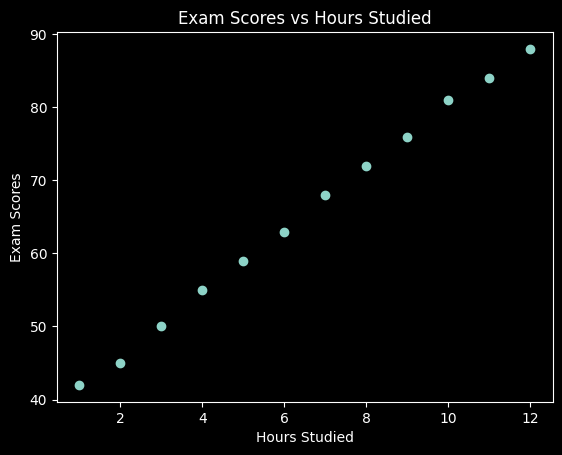

In [30]:
data = pd.read_csv('glm.csv')
# Convert to NumPy
X = np.array(data['hours_studied'])
y = np.array(data['exam_scores'])

# Reshape X to 2D
X = X.reshape(-1, 1)

# Add bias term
X = np.hstack([np.ones((X.shape[0], 1)), X])

plt.scatter(X[:,1], y)
plt.xlabel('Hours Studied')
plt.ylabel('Exam Scores')
plt.title('Exam Scores vs Hours Studied')
print("Min:", y.min())
print("Max:", y.max())
print("Unique values:", np.unique(y)[:10])
print("Is integer:", np.all(np.mod(y, 1) == 0))

In [31]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [32]:
def Gaussian_glm(X, y, lr=0.01, epochs=1000):
    theta = np.zeros(X.shape[1])

    for _ in range(epochs):
        mu = X @ theta
        grad = X.T @ (mu - y) / len(y)
        theta -= lr * grad

    return theta


In [33]:
#Bernoulli GLM
def Bernoulli_glm(X, y, lr=0.01, epochs=1000):
    theta = np.zeros(X.shape[1])

    for _ in range(epochs):
        z = X @ theta
        p = sigmoid(z)
        grad = X.T @ (p - y) / len(y)
        theta -= lr * grad

    return theta


In [34]:
def Poisson_glm(X, y, lr=0.01, epochs=1000):
    theta = np.zeros(X.shape[1])

    for _ in range(epochs):
        z = X @ theta
        mu = np.exp(z)
        grad = X.T @ (mu - y) / len(y)
        theta -= lr * grad

    return theta


In [41]:
def Gaussian_loglik(y, mu):
    resid = y - mu
    sigma2 = np.mean(resid**2)
    n = len(y)
    return -0.5 * n * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(resid**2) / sigma2


def Bernoulli_loglik(y, p):
    eps = 1e-9
    return np.sum(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

def Poisson_loglik(y, mu):
    return np.sum(y * np.log(mu + 1e-9) - mu)


In [47]:
# To check which distribution to use
def candidate_distributions(y):
    candidates = []

    # Bernoulli: strictly binary outcomes
    if np.all(np.isin(y, [0, 1])):
        candidates.append("bernoulli")

    # Poisson: count data (small non-negative integers, unbounded)
    if np.all(y >= 0) and np.all(y.astype(int) == y):
        if y.max() < 50:          # key heuristic
            if np.var(y) / np.mean(y) < 2:
                candidates.append("poisson")

    # Gaussian: real-valued OR bounded numeric outcomes
    if y.min() < 0 or y.max() > 1:
        candidates.append("gaussian")

    return candidates



candidates = candidate_distributions(y)
thetas = {}
results = {}

thetas = {}

for dist in candidates:
    if dist == "bernoulli":
        theta = Bernoulli_glm(X, y)
        ll = Bernoulli_loglik(y, sigmoid(X @ theta))

    elif dist == "poisson":
        theta = Poisson_glm(X, y)
        ll = Poisson_loglik(y, np.exp(X @ theta))

    elif dist == "gaussian":
        theta = Gaussian_glm(X, y)
        ll = Gaussian_loglik(y, X @ theta)

    results[dist] = ll
    thetas[dist] = theta

best_model = max(results, key=results.get)
best_theta = thetas[best_model]
print(f"Best model: {best_model} with log-likelihood: {results[best_model]}")

Best model: gaussian with log-likelihood: -25.45378437319906


In [48]:
def predict_glm(X_new, theta, model):
    z = X_new @ theta

    if model == "gaussian":
        return z

    elif model == "bernoulli":
        return sigmoid(z)

    elif model == "poisson":
        return np.exp(z)

    else:
        raise ValueError("Unknown model")


In [49]:
y_hat = predict_glm(X, best_theta, best_model)


In [50]:
x_new = np.array([7])
x_new = x_new.reshape(1, 1)
x_new = np.hstack([np.ones((1, 1)), x_new])

y_pred = predict_glm(x_new, best_theta, best_model)
print("Predicted exam score:", y_pred[0])


Predicted exam score: 66.73763307219704


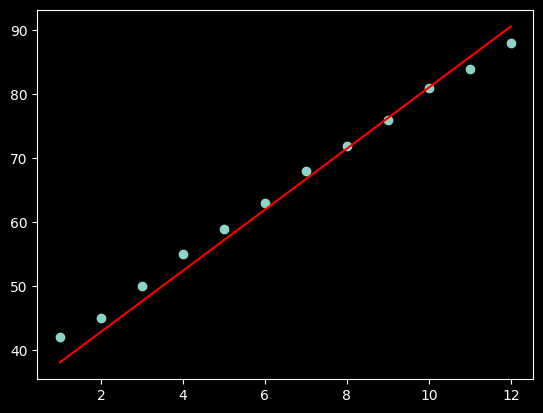

In [51]:
x_plot = np.linspace(X[:,1].min(), X[:,1].max(), 100)
X_plot = np.column_stack([np.ones(100), x_plot])

y_plot = predict_glm(X_plot, best_theta, best_model)

plt.scatter(X[:,1], y)
plt.plot(x_plot, y_plot, color='red')
plt.show()
